In [2]:
import pandas as pd
import numpy as np

# 1) Load
trials = pd.read_csv('Oddball_data_exported_trials_20250527.csv')   # per-trial rows
days   = pd.read_csv('Oddball_data_exported_20250527.csv')          # per-day rows

print(days.columns)

print(trials.columns)

import pandas as pd
import numpy as np

days = days.loc[days['genotype'] == 'WT']
days = days.loc[days['rat_name'] == 'RP4']
days = days.loc[days['position'] == 4]
days = days[['date', 'file_name', 'task', 'UUID']]

trials = trials.loc[trials['rat_ID'] == 140]


trials = trials[['Stim_ID', 'Trial_type', 'UUID', 'Trial_number', 'Response', 'Reaction_(s)']]

days_trials = trials.merge(days, on='UUID', how='inner')

days_trials = days_trials[['date', 'Trial_number', 'task', 'Trial_type', 'file_name', 'Stim_ID', 'Reaction_(s)', 'Response']]

days_trials.columns = ['Date', 'Trial_number', 'Global', 'Trial_logic', 'Frequency', 'Position', 'Decision', 'Response']

days_trials['Trial_logic'] = days_trials['Trial_logic'].replace({5: 'HM', 0: 'FC'})
days_trials['Trial_logic'] = pd.Categorical(days_trials['Trial_logic'], categories=['HM','FC'])

days_trials['Frequency'] = (
    days_trials['Frequency']
    .astype(str)
    .str.extract(r'(?i)(\d+)\s*kHz', expand=False)  # case-insensitive 'kHz'
    .astype(int)
)

days_trials = days_trials.loc[days_trials['Global'].isin(['Base case', 'Probe trials', 'Catch trials'])]

# Masks
m_HM   = days_trials['Trial_logic'].eq('HM')
m_FC   = days_trials['Trial_logic'].eq('FC')
m_Hit  = days_trials['Response'].eq('Hit')
m_FA   = days_trials['Response'].eq('FA')
m_Miss = days_trials['Response'].eq('Miss')
m_CR   = days_trials['Response'].eq('CR')

# Helper: numeric versions
pos_num = pd.to_numeric(
    days_trials['Position'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)
dec_num = pd.to_numeric(days_trials['Decision'], errors='coerce')

# Floor-division by 0.750 then +1 (use floor to match // semantics with floats)
fa_calc = (np.floor(dec_num / 0.750) + 1).astype('Int64')

# 1) HM & Hit  -> Decision = Position
days_trials.loc[m_HM & m_Hit, 'Decision'] = pos_num[m_HM & m_Hit]

# 2) HM & FA   -> Decision = (Decision // 0.750) + 1
days_trials.loc[m_HM & m_FA, 'Decision'] = fa_calc[m_HM & m_FA]

# 3) HM & Miss -> Decision = -1
days_trials.loc[m_HM & m_Miss, 'Decision'] = -1

# 4) FC & CR   -> Decision = 7
days_trials.loc[m_FC & m_CR, 'Decision'] = 7

# 5) FC & FA   -> Decision = (Decision // 0.750) + 1
days_trials.loc[m_FC & m_FA, 'Decision'] = fa_calc[m_FC & m_FA]

# print(trials)

days_trials = days_trials[['Date', 'Global', 'Trial_number', 'Frequency', 'Position', 'Decision']]

days_trials['Decision'] = days_trials['Decision'] - 1
days_trials['Position'] = days_trials['Position'] - 1

print(days_trials)

Index(['date', 'rat_name', 'rat_ID', 'DOB', 'Sex', 'Genotype', 'HL_date',
       'file_name', 'experiment', 'phase', 'task', 'detail', 'stim_type',
       'analysis_type', 'complete_block_count', 'trial_count', 'hit_percent',
       'FA_percent', 'UUID', 'position', 'FA', 'trials', 'FA_percent_detailed',
       'Dur (ms)', 'Freq (kHz)', 'Rxn', 'line', 'genotype'],
      dtype='object')
Index(['Time_since_file_start_(s)', 'Stim_ID', 'Trial_type',
       'Attempts_to_complete', 'Response', 'Reaction_(s)', 'Type',
       'Stim Source', 'Freq (kHz)', 'Inten (dB)', 'Dur (ms)',
       'Nose Out TL (s)', 'Time Out (s)', 'Train Setting',
       'Extra Check Point (s)', 'Delay (s)', 'Trial_number', 'Block_number',
       'complete_block_number', 'UUID', 'rat_ID', 'rat_name', 'DOB', 'Sex',
       'Genotype', 'HL_date'],
      dtype='object')
           Date     Global  Trial_number  Frequency  Position  Decision
6125   20230502  Base case             1          4         5       2.0
6126   20230

In [3]:
# already sorted & reindexed:
days_trials = days_trials.sort_values(['Date','Trial_number']).reset_index(drop=True)

def find_intervals_by_index(df, label_value, label_col='Global'):
    # True where we're in the target phase
    mask = df[label_col].astype(str).str.strip().str.casefold().eq(label_value.casefold())
    # New run whenever mask flips (contiguous by row index)
    run_id = mask.ne(mask.shift()).cumsum()

    out = (df.loc[mask]
             .assign(row=lambda d: d.index)                # capture row index
             .groupby(run_id[mask], as_index=False)
             .agg(start_row=('row','min'),
                  end_row=('row','max'),
                  n_rows=('row','size'),
                  start_trial=('Trial_number','first'),
                  end_trial=('Trial_number','last'))
          )
    out.insert(0, 'label', label_value)
    return out

probe_intervals = find_intervals_by_index(days_trials, 'Probe trials')
catch_intervals = find_intervals_by_index(days_trials, 'Catch trials')

print("Probe intervals:\n", probe_intervals.to_string(index=False))
print("\nCatch intervals:\n", catch_intervals.to_string(index=False))


Probe intervals:
        label  start_row  end_row  n_rows  start_trial  end_trial
Probe trials       5410     5786     377            1        377
Probe trials       6506     6871     366            1        366
Probe trials       7900     8280     381            1        381
Probe trials       9022     9389     368            1        368
Probe trials      10138    10513     376            1        376
Probe trials      11244    11609     366            1        366
Probe trials      12307    12684     378            1        378
Probe trials      13391    13724     334            1        334
Probe trials      17545    17751     207            1        207
Probe trials      18479    18818     340            1        340
Probe trials      19092    19490     399            1        399
Probe trials      19854    20239     386            1        386
Probe trials      20436    20815     380            1        380
Probe trials      21214    21567     354            1        354
Probe t

C:\Users\Fatbu\AppData\Local\Temp\ipykernel_35040\3510368493.py:13: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  .agg(start_row=('row','min'),
C:\Users\Fatbu\AppData\Local\Temp\ipykernel_35040\3510368493.py:13: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  .agg(start_row=('row','min'),


### Perceptual Decision Making

In [4]:
import numpy as np
from scipy.stats import norm

#finds the respective standard deviation for the position and frequency
def sigma_matrix(pos_sigma, freq_sigma):
    pos_sigma = np.asarray(pos_sigma)
    freq_sigma = np.asarray(freq_sigma)
    
    # Broadcast: (4,1) + (1,7) → (4,7)
    mat = np.exp(freq_sigma[:, None] + pos_sigma[None, :])
    return mat

#noise = P(O_t+1 | true k_t, freq_t)
#prior = P(O_t+1 | O_1:t)
#P(O_t+1 | O_1:t, true k_t, freq_t)
def gaussian_overlap_weights(prior, means, sigma_matrix_, f_idx, true_k):
    mean_q = means[true_k]
    sigma_q = sigma_matrix_[f_idx][true_k]
    means = np.asarray(means, float)
    sigmas = np.asarray(sigma_matrix_[f_idx], float)

    var_sum = sigma_q**2 + sigmas**2
    noise = -0.5*np.log(2*np.pi*var_sum) - 0.5*((means - mean_q)**2)/var_sum

    #have to deal with zeros in log
    prior = np.asarray(prior, float)
    logprior = np.log(prior)

    decision_prior = noise + logprior

    # softmax to get a length-7 vector summing to 1, lose information if value is more than 10^14 apart
    m = np.max(decision_prior)
    w = np.exp(decision_prior - m)
    return w / w.sum()


#Higher lamdha means more bias towards FAing at 1 - 3
def apply_lapse(lamdha, decision_prior):
    return (1.0 - lamdha)*decision_prior + lamdha * np.array([1/3, 1/3, 1/3, 0, 0, 0, 0])

### Modeling

In [5]:
import numpy as np
import matplotlib.pyplot as plt

observations = ['Dev at 1', 'Dev at 2','Dev at 3','Dev at 4','Dev at 5','Dev at 6', 'No deviant']
frequencies = [4, 8, 16, 32]


def change_point_model(lamdha_param = None, pos_sigma_param = None, freq_sigma_param = None):
    

    ######## Initialize Global Variables ########
    
    def initialize_likelihoods(lamdha_ = None, pos_sigma_ = None, freq_sigma_ = None):

        trial_by_global = np.array([
        # HM FC
        #standard        
        [1, 0],
        #probe
        [0.6, 0.4],
        #catch
        [0.96, 0.04]
        ]).T

        trial_logic = np.array([
        #HM
        [0, 0, 0, 0.33, 0.33, 0.33, 0],
        #FC
        [0, 0, 0, 0, 0, 0, 1]
        ]).T

        FUTURE_GIVEN_STATE = trial_logic @ trial_by_global

        means = np.array([1, 2, 3, 4, 5, 6, -2]) ### Farther Mu doesn't affect it for some reason?

        lamdha = lamdha_

        matrix = sigma_matrix(pos_sigma_, freq_sigma_)

        return trial_by_global, trial_logic, FUTURE_GIVEN_STATE, means, lamdha, matrix

    trial_by_global, trial_logic, FUTURE_GIVEN_STATE, means, lamdha, sigs = initialize_likelihoods(lamdha_param, pos_sigma_param, freq_sigma_param)



    ######## HELPER FUNCTIONS FOR INTERNAL BELIEF UPDATING ########





    def initialize_priors_and_history(global_prior = None, belief_over_time = None, decision_over_time = None, decision_history = None):
        if (belief_over_time is None or decision_history is None or decision_over_time is None):          
            global_prior = np.array([1/3, 1/3, 1/3])
            belief_over_time = [] 
            decision_over_time = []
            decision_history = []

        else:
            global_prior = global_prior
            belief_over_time = belief_over_time  
            decision_over_time = decision_over_time
            decision_history = decision_history

        deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])      

        return deviant_given_sequence, global_prior, belief_over_time, decision_over_time, decision_history

    def sequence_given_state(sequence, trial_by_global, trial_logic):
        deviant_given_state = np.ones(3)
        for i in range(len(sequence)):
            if (sequence[i] == 'FA/Miss'):
                continue
            deviant_given_trial = np.array([trial_logic[sequence[i]][0], trial_logic[sequence[i]][1]])
            deviant_given_state *= deviant_given_trial @ trial_by_global
            deviant_given_state = deviant_given_state / deviant_given_state.sum()

        return deviant_given_state

    #state_prob (just the global type probability) is 1/3 for all three, could change to free
    #doesn't really matter here since uniform for all three but if we want to change overall chance between global types do it here
    def state_given_sequence(sequence, state_prob, trial_by_global, trial_logic):
        SEQUENCE_GIVEN_STATE = sequence_given_state(sequence, trial_by_global, trial_logic)
        state_given_sequence = SEQUENCE_GIVEN_STATE * state_prob
        norm_state_given_sequence = state_given_sequence / state_given_sequence.sum()
        return norm_state_given_sequence

    def future_given_sequence(sequence, prior, trial_by_global, trial_logic):
        STATE_GIVEN_SEQUENCE = state_given_sequence(sequence, prior, trial_by_global, trial_logic)    
        
        return FUTURE_GIVEN_STATE @ STATE_GIVEN_SEQUENCE.T

    def update_priors_simplified(global_prior, trial_by_global, trial_logic, decision_history):    

        deviant_given_sequence = future_given_sequence(decision_history, global_prior, trial_by_global, trial_logic)

        return deviant_given_sequence


    




    ######## FUNCTION FOR RUNNING TRIALS ########




    #decision_over_time is prior of possible choices the agent wants to make
    #decision_history is the single choice that was randomly sampled from each prior (decision_over_time) for each trial
    def run_trials(global_prior_ = None, belief_over_time_ = None, decision_over_time_ = None, decision_history = None):

        deviant_given_sequence, global_prior, belief_over_time, decision_over_time, decision_history = initialize_priors_and_history(global_prior_, 
                                                                                        belief_over_time_, decision_over_time_, decision_history)
        
        
        dates = days_trials['Date'].unique() #in ascending order

        for date in dates:
            df_copy = days_trials.copy()
            df_copy = df_copy.loc[df_copy['Date'] == date]  

            block_history = []

            for trial in range(len(df_copy['Trial_number'])):
                deviant_position = int(df_copy.iloc[trial]['Position'])
                f_val = int(df_copy.iloc[trial]['Frequency'])   # get the value at this trial
                f_index = frequencies.index(f_val)

                noisey_observation = gaussian_overlap_weights(deviant_given_sequence, means, sigs, f_index, deviant_position)
                more_noisey_observation = apply_lapse(lamdha, noisey_observation)
                decision_over_time.append(more_noisey_observation)

                # Randomly choose a decision using this noisey observation
                choice_index = np.random.choice(len(more_noisey_observation), p=more_noisey_observation)
                decision_from_observation = choice_index
                
                #If FA early no meaningful update so just keep same belief. Also just only reinforce if hit/CR
                if (decision_from_observation != deviant_position):
                    if (trial == 0):
                        deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])
                    else:
                        deviant_given_sequence = belief_over_time[len(belief_over_time) - 1]
                    decision_history.append('FA/Miss')
                    block_history.append('FA/Miss')

                    belief_over_time.append(deviant_given_sequence)
                    continue
                else:
                    decision_history.append(decision_from_observation)
                    block_history.append(decision_from_observation)


                # After each trial, update the predicted observation based on the new decision sequence
                deviant_given_sequence = update_priors_simplified(global_prior, trial_by_global, trial_logic, block_history)
                belief_over_time.append(deviant_given_sequence.copy())

        
        return belief_over_time, decision_over_time, decision_history

    global_prior = np.array([1/3, 1/3, 1/3])

    belief_over_time, decision_over_time, decision_history = run_trials()


    # Step 4: Plot the belief evolution over time
    def plot_belief_evolution(belief_over_time,
                          probe_intervals=None,
                          catch_intervals=None,
                          figsize=(10, 6),
                          savepath="exponential_bias.svg"):

        B = np.asarray(belief_over_time)
        T = B.shape[0]

        fig, ax = plt.subplots(figsize=figsize)

        # Positions 1..6
        for i in range(6):
            ax.plot(B[:, i], label=f"Position {i+1}", linewidth=1.5)

        # Position 7 as "No deviant"
        ax.plot(B[:, 6], label="No deviant", linestyle='--', color='black', linewidth=1.5)

        # ---- Mark Probe blocks: single vertical line at block start ----
        if probe_intervals is not None and len(probe_intervals) > 0:
            added_probe_label = False
            for _, r in probe_intervals.iterrows():
                x = int(r['start_row'])
                ax.axvline(x=x, color='tab:red', linestyle='--', linewidth=1.2, alpha=0.9,
                        label=None if added_probe_label else "Probe start")
                added_probe_label = True

        # ---- Mark Catch blocks: shaded span + thin boundary lines ----
        if catch_intervals is not None and len(catch_intervals) > 0:
            added_catch_span_label = False
            added_catch_edge_label = False
            for _, r in catch_intervals.iterrows():
                xs, xe = int(r['start_row']), int(r['end_row'])
                ax.axvspan(xs, xe, color='tab:blue', alpha=0.08,
                        label=None if added_catch_span_label else "Catch interval")
                added_catch_span_label = True
                # optional boundary lines for extra clarity
                ax.axvline(x=xs, color='tab:blue', linestyle='-', linewidth=0.8, alpha=0.6,
                        label=None if added_catch_edge_label else "Catch boundary")
                ax.axvline(x=xe, color='tab:blue', linestyle='-', linewidth=0.8, alpha=0.6,
                        label=None)
                added_catch_edge_label = True

        ax.set_xlim(0, T-1)
        ax.set_xlabel("Trial")
        ax.set_ylabel("Belief")
        ax.set_title("Evolution of Belief Over Time")

        # legend outside on the right
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg = ax.legend(
            by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1.02, 0.5),
            title='Legend',                  # ← title text
            frameon=True, fancybox=True,     # ← show box
            framealpha=1.0,                  # opaque box
            edgecolor='0.3',                 # box outline color
            ncol=1, fontsize=9, title_fontsize=10,
            borderpad=0.3, labelspacing=0.3, handlelength=1.2, handletextpad=0.5
        )
        leg.get_frame().set_linewidth(1.0)   # optional: thicker border


        plt.tight_layout()
        plt.savefig("Omniscient.svg", format="svg", bbox_inches="tight")
        plt.show()
    
    plot_belief_evolution(np.asarray(belief_over_time),
                      probe_intervals=probe_intervals,
                      catch_intervals=catch_intervals)


    return decision_over_time




### Model Fitting

[2. 3. 3. ... 3. 5. 4.]


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_35040\2455211506.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


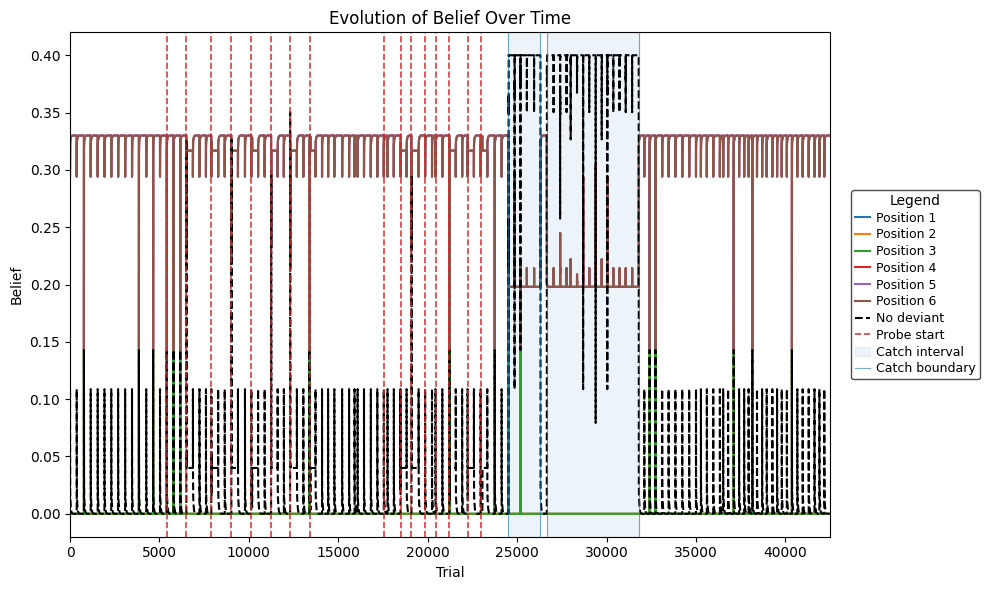

-28192.844882391157


In [6]:
from bayes_opt import BayesianOptimization
import math

data = days_trials['Decision'].to_numpy()
deviant_data = days_trials['Position'].to_numpy()

print(data)

#f1 set to zero as reference variance
def neg_log_likelihood():

    pos_sigma_ = np.array([1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0])
    freq_sigma_ = np.array([-1.0, -1.0, -1.0, -1.0 ])

    pos_sigma_ -= pos_sigma_.mean()
    freq_sigma_ -= freq_sigma_.mean()

    priors = change_point_model(0.001, pos_sigma_, freq_sigma_)
    priors = np.asarray(priors, dtype=float)

    if len(priors) != len(data):
        raise ValueError(f"Length mismatch: priors={len(priors)} vs data={len(data)}")

    # floor + nan guard
    eps = 1e-12
    priors = np.where(np.isfinite(priors), priors, 0.0)
    priors = np.maximum(priors, eps)

    nll = 0.0
    for i in range(len(priors)):
        k = int(data[i])           # your Decision column (already minus 1)
        if k == -2:
            t = int(deviant_data[i])   # 0-based true dev position; -1 if unknown
            p = priors[i, 0:t].sum()   # probability of choosing any bin AFTER true dev
        elif (k == 7):
            continue
        else:
            # normal case: probability of the chosen bin
            p = priors[i, k]                  # belief mass at that class
        nll -= math.log(p)                # accumulate negative log-likelihood
    return -nll

print(neg_log_likelihood())
# # Define bounds for each parameter (between 0.01 and 0.99 to avoid degenerate values)
# pbounds = {
#     'lamdha_': (0.0001, 0.001),
#     'a1': (-1, 1),
#     'a2': (-1, 1),
#     'a3': (-1, 1),
#     'a4': (-1, 1),
#     'a5': (-1, 1),
#     'a6': (-1, 1),
#     'a7': (-1, 1),
#     'f1': (-1, 1),
#     'f2': (-1, 1),
#     'f3': (-1, 1),
#     'f4': (-1, 1),
# }

# # Initialize the optimizer
# optimizer = BayesianOptimization(
#     f=neg_log_likelihood,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# # Run optimization
# optimizer.maximize(
#     init_points=10,  # random samples before GP fitting
#     n_iter=20        # number of iterations of Bayesian optimization
# )    

In [7]:
 -28391.66 | 0.001  lamdha   | 1.0       | 1.0       | 0.9013229 | -1.0      | -1.0      | -1.0      | 1.0       | -1.0      | -1.0      | -1.0      | -1.0  

SyntaxError: invalid syntax (3592324943.py, line 1)

C:\Users\Fatbu\AppData\Local\Temp\ipykernel_23896\2455211506.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


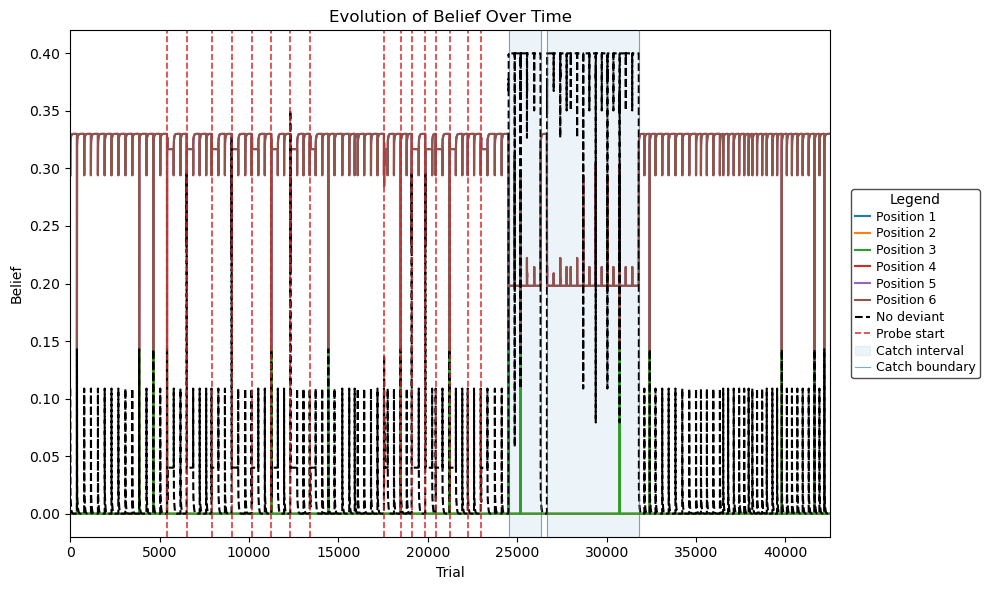

[array([1.80857749e-02, 3.88171594e-02, 6.59358308e-02, 5.66350215e-05,
        7.35814255e-02, 8.02902061e-01, 6.21113218e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 9.12420067e-01,
        8.36181303e-02, 6.43601911e-05, 2.89744256e-03]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 6.45354700e-05,
        8.38458564e-02, 9.14904957e-01, 1.84650672e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 6.45388720e-05,
        8.38502763e-02, 9.14953186e-01, 1.31998410e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 7.73461708e-02,
        8.43982019e-01, 7.73461708e-02, 3.25639763e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 9.14314936e-01,
        8.37917843e-02, 6.44938511e-05, 8.28786128e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 7.73557641e-02,
        8.44086698e-01, 7.73557641e-02, 2.01773535e-04]),
 array([3.33333333e-04, 3.33333333e-04, 3.33333333e-04, 9.14461892e-01,
        8.38052520

In [ ]:
pos_sigma_ = np.asarray([1.0, 1.0, 0.9013229, -1.0, -1.0, -1.0, 1.0 ])
pos_sigma_ -= pos_sigma_.mean()

freq_sigma_ = np.asarray([-1.0, -1.0, -1.0, -1.0])
freq_sigma_ -= freq_sigma_.mean()



change_point_model(0.001, pos_sigma_, freq_sigma_)